In [3]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectFromModel




In [4]:
df = pd.read_csv('magneticmoment_Ef_data.csv', header=0)


In [3]:
tmp = []
for j in range(len(df.columns)):
    if( not (isinstance(df.iloc[0][j], np.float64) or isinstance(df.iloc[0][j], np.int64)) ):
        tmp.append(df.columns[j])

#print(tmp)
df = df.drop(columns=tmp)


In [4]:
#remove what we want to predict
to_predict = ['formation_energy', 'magnetic_moment']
# labels = df[to_predict[0]]


# df = df.drop(columns=to_predict)
X= df.drop(to_predict, axis=1)
y = df[to_predict[1]]

In [14]:
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets

def make_train_test_split(features, labels):
    return train_test_split(features, labels, test_size = 0.40, random_state = 421)
   


def get_r_sq(predictions, test_labels):
    r_sq = metrics.r2_score(predictions, test_labels)
    return r_sq

def train_model(X_train, y_train):
    """Train an Extra Trees Regression model with hyperparameter tuning."""
    param_grid = {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

# ... (previous code omitted for brevity)

# from sklearn.feature_selection import SelectFromModel

# def train_model(X_train, y_train):
#     """Train an Extra Trees Regression model with hyperparameter tuning and feature selection."""
#     param_grid = {
#         'n_estimators': [50, 100, 200, 300, 500],
#         'max_depth': [None, 5, 10],
#         'min_samples_split': [2, 5, 10],
#         'max_features': ['auto', 'sqrt', 'log2']
#     }

#     model = ExtraTreesRegressor(random_state=421)
#     grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#     grid_search.fit(X_train, y_train)
    
#     best_model = grid_search.best_estimator_
#     return best_model



def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model on the test set using R-squared."""
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def plot_predictions(y_test, y_pred, r2):
    """Plot the model's predictions against the true values with R-squared in the legend."""
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'R-squared = {r2:.3f}')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values')
    plt.legend()
    plt.show()

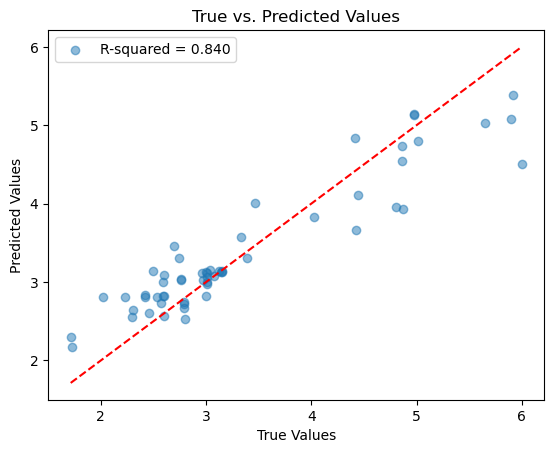

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train the model with hyperparameter tuning
model = train_model(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = evaluate_model(model, X_test, y_test)

# Plot the predictions
plot_predictions(y_test, y_pred, r2)

Evaluate the following values for max_depth :  [ 1  2  3  4  5  6  7  8  9 10]


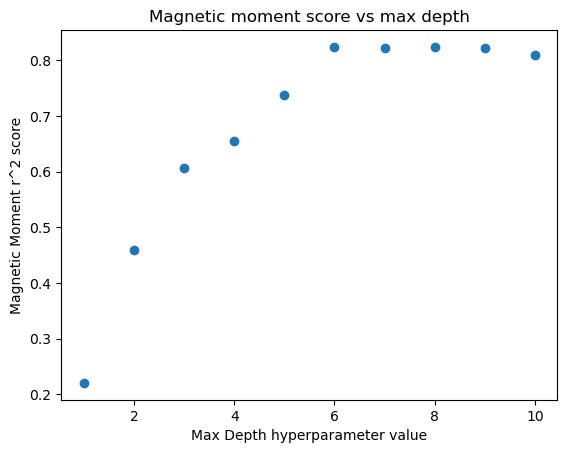

In [7]:
def hyper_search(X_train, y_train, X_val, y_val):
  """
  function that searches evaluates a list of hyperparameters
  """
  max_depth_values = np.arange(10)+1
  print("Evaluate the following values for max_depth : ", max_depth_values)
  scores = []
  for ith, max_depth in enumerate(max_depth_values):
    rf_model_i = RandomForestRegressor(max_depth=max_depth, n_estimators = 5, random_state=0)
    rf_model_i.fit(X_train, y_train)
    score = rf_model_i.score(X_val, y_val)
    scores.append(score)
    # print(ith, score)
  return max_depth_values, scores

X = df[['std_ion', 'nvalence_avg', 'dipole_max_dif', 'dipole_std_dif','atomic_vol_max_dif','atomic_rad_max_dif']]
X = np.asarray(X)

y = df['magnetic_moment'].values

# Modify the code below using the training data you created previously
# What is the best hyperparameter for the model?
X_train = X[:100,:4]
y_train = y[:100]
X_val = X[50:80,:4]
y_val = y[50:80]

max_depth_values, scores = hyper_search(X_train, y_train, X_val, y_val)
plt.scatter(max_depth_values, scores)
# add axis labels
plt.xlabel('Max Depth hyperparameter value')
plt.ylabel('Magnetic Moment r^2 score')
plt.title('Magnetic moment score vs max depth')
plt.show()

# type code to determine the best hyperparameter for the model below:

# BONUS [come back to this if there's time]:
# Modify code in function to calculate both training and validation predictions/scores
# Plot both the training and test scores

Evaluate the following values for max_depth :  [ 1  2  3  4  5  6  7  8  9 10]


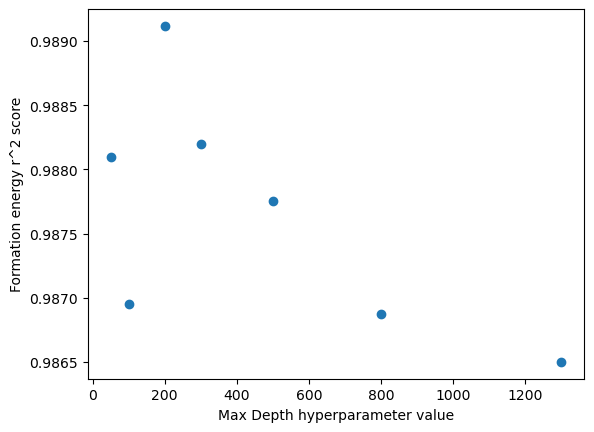

In [16]:
# write your code here

def hyper_search_2d(X_train, y_train, X_val, y_val):
  """
  function that searches evaluates a list of hyperparameters
  """
  max_depth_values = np.arange(10)+1
  n_estimators = [50, 100, 200, 300, 500, 800, 1300]

  print("Evaluate the following values for max_depth : ", max_depth_values)
  scores_i = []
  for ith, max_depth in enumerate(max_depth_values):
    scores_j = []
    for jth, n_est in enumerate(n_estimators):
      rf_model_ij = RandomForestRegressor(max_depth=max_depth, n_estimators = n_est, random_state=0)
      rf_model_ij.fit(X_train, y_train)
      score = rf_model_ij.score(X_val, y_val)
      scores_j.append(score)
    scores_i.append(scores_j)
      # print(ith, score)
  return max_depth_values, n_estimators, scores_i


X = df[['std_ion', 'nvalence_avg', 'dipole_max_dif', 'dipole_std_dif','atomic_vol_max_dif','atomic_rad_max_dif']]
X = np.asarray(X)

y = df['formation_energy'].values

# Modify the code below using the training data you created previously
# What is the best hyperparameter for the model?
X_train = X[:100,:4]
y_train = y[:100]
X_val = X[50:80,:4]
y_val = y[50:80]

max_depth_values, n_estimators, scores = hyper_search_2d(X_train, y_train, X_val, y_val)
plt.scatter(n_estimators, scores[7])
# add axis labels
plt.xlabel('Max Depth hyperparameter value')
plt.ylabel('Formation energy r^2 score')
plt.show()